# **Section 1**


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"


In [ ]:
!pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = (SparkSession
 .builder
 .appName("IPL")
 .getOrCreate())


In [ ]:
df_matches = spark.read.load("ipl_matches.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

In [ ]:
df_venue = spark.read.load("ipl_venue.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

In [ ]:
df_ball_by_ball = spark.read.load("ipl_ball_by_ball.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

In [ ]:
df_venue.createOrReplaceTempView('Venues')
df_matches.createOrReplaceTempView('IPLmatches')
df_ball_by_ball.createOrReplaceTempView('Ballbyball')

In [ ]:
spark.catalog.listTables()

[Table(name='ballbyball', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='iplmatches', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='venues', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [ ]:
df_venue.show()

+--------+--------------------+--------------+
|venue_id|               venue|          city|
+--------+--------------------+--------------+
|       1|Dr. Y.S. Rajasekh...| Visakhapatnam|
|       2|Sharjah Cricket S...|       Sharjah|
|       3|JSCA Internationa...|        Ranchi|
|       4|Saurashtra Cricke...|        Rajkot|
|       5|Shaheed Veer Nara...|        Raipur|
|       6|Maharashtra Crick...|          Pune|
|       7|Subrata Roy Sahar...|          Pune|
|       8|    St George's Park|Port Elizabeth|
|       9|Vidarbha Cricket ...|        Nagpur|
|      12|   Brabourne Stadium|        Mumbai|
|      13|Dr DY Patil Sport...|        Mumbai|
|      14|    Wankhede Stadium|        Mumbai|
|      15|        Eden Gardens|       Kolkata|
|      16|       Nehru Stadium|         Kochi|
|      17|De Beers Diamond ...|     Kimberley|
|      18|          Green Park|        Kanpur|
|      19|New Wanderers Sta...|  Johannesburg|
|      20|Sawai Mansingh St...|        Jaipur|
|      21|Hol

In [ ]:
df_matches.show()

+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+-----------+--------------+
|match_id|      date|player_of_match|venue_id|neutral_venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|eliminator|method|    umpire1|       umpire2|
+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+-----------+--------------+
|  335982|2008-04-18|    BB McCullum|      35|            0|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knight Ri...|   runs|          140|         N|    NA|  Asad Rauf|   RE Koertzen|
|  335983|2008-04-19|     MEK Hussey|      31|            0|     Kings XI Punjab| Chennai Super 

In [ ]:
df_ball_by_ball.show()

+--------+------+-----+----+-------------+-------------+------------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------------+
|match_id|inning|overs|ball|      batsman|  non_striker|      bowler|batsman_runs|extra_runs|total_runs|non_boundary|is_wicket|dismissal_kind|player_dismissed|fielder|extras_type|        batting_team|        bowling_team|
+--------+------+-----+----+-------------+-------------+------------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------------+
|  419157|     2|   16|   4|      V Kohli|R Vinay Kumar|CRD Fernando|           0|         0|         0|           0|        0|            NA|              NA|     NA|         NA|Royal Challengers...|      Mumbai Indians|
|  419157|     2|   16|   5|      V Kohli|R Vinay Kumar|CRD Fernando|           1|         0|         1|        

# **Section 2**

### **1. Top 3 venues which hosted the most number of eliminator matches**

In [ ]:
eli_venue=df_matches.where(df_matches.eliminator=="Y").groupBy('venue_id').count()
# eli_venue.sort('count',ascending=False).show()
q1=eli_venue.join(df_venue,['venue_id'],"inner")
q1.sort('count',ascending=False).show(3)

+--------+-----+--------------------+---------+
|venue_id|count|               venue|     city|
+--------+-----+--------------------+---------+
|      25|    3|Dubai Internation...|    Dubai|
|      38|    2|Sheikh Zayed Stadium|Abu Dhabi|
|      27|    1|    Feroz Shah Kotla|    Delhi|
+--------+-----+--------------------+---------+
only showing top 3 rows



There are only 10 venues where the eliminator matches took place. Except two stadiums all other stadiums hosted only one eliminator match. Amoung those stadiums Dubai International and Sheikh Zayed stadiums are the top most, which hosted 3 and 2 eliminator matches respectively.

### **2. Most number of catches taken by a player in IPL history**

In [ ]:
caught=df_ball_by_ball.where(df_ball_by_ball.dismissal_kind=="caught").groupBy('fielder').count()
caught=caught.withColumnRenamed('count','catches')
caught.sort('catches',ascending=False).show(1)

+----------+-------+
|   fielder|catches|
+----------+-------+
|KD Karthik|    118|
+----------+-------+
only showing top 1 row



KD Karthik has taken the most number of catches in IPL history.He took 118 number of catches.

### **3. Highest wicket taker in matches which were affected by D/L method**

In [ ]:
method=df_matches.where(df_matches.method=='D/L')
# method.show()
wicket=df_ball_by_ball.join(method,['match_id'],"inner")
# wicket.show()
q3=wicket.where(wicket.is_wicket=='1').groupBy('bowler').count()
q3=q3.withColumnRenamed('count','wickets')
q3.sort('wickets',ascending=False).show(1)

+--------+-------+
|  bowler|wickets|
+--------+-------+
|R Ashwin|      8|
+--------+-------+
only showing top 1 row



R Ashwin got the highest number of wickets in matches which were affected by Duckworth-Lewis's method (D/L method).

### **4. Highest Strike rate by a batsman in non powerplay overs**

In [ ]:
powerplay_overs=df_ball_by_ball.where((df_ball_by_ball.overs >=7)&(df_ball_by_ball.overs<=20)&(df_ball_by_ball.extras_type!='wides')&
                                      (df_ball_by_ball.extras_type!='noballs'))
# powerplay_overs.show()
total=powerplay_overs.groupBy('batsman').sum('total_runs','ball')
# total.show()
from pyspark.sql.functions import col
q4=total.withColumn('Strike_rate',((col('sum(total_runs)')/col('sum(ball)'))*100))
q4.sort('Strike_rate',ascending=False).show(1)

+------------+---------------+---------+-----------+
|     batsman|sum(total_runs)|sum(ball)|Strike_rate|
+------------+---------------+---------+-----------+
|Vishnu Vinod|              9|       12|       75.0|
+------------+---------------+---------+-----------+
only showing top 1 row



Highest strike rate by a batsman in non powerplay overs is 75.

### **5. Highest extra runs in a venue(stadium,city)**

In [ ]:
extra_runs=df_ball_by_ball.where(df_ball_by_ball.extra_runs!=0).groupBy('match_id').sum('extra_runs')
# extra_runs.show()
venue=df_matches.join(extra_runs,['match_id'],'inner')
# venue.show()
q5=df_venue.join(venue,['venue_id'],"inner")
q5=q5.withColumnRenamed('sum(extra_runs)','total')
q5.sort('total',ascending=False).show(10)

+--------+--------------------+----------+--------+----------+---------------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+--------------+--------------+-----+
|venue_id|               venue|      city|match_id|      date|player_of_match|neutral_venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|eliminator|method|       umpire1|       umpire2|total|
+--------+--------------------+----------+--------+----------+---------------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+--------------+--------------+-----+
|      12|   Brabourne Stadium|    Mumbai|  419132|2010-03-30|     SL Malinga|            0|      Mumbai Indians|     Kings XI Punjab|      Mumbai Indians|        field|      Mumbai Indians|wickets| 

Highest extra runs scored is 38 and there are two venues where the highest extra runs is scored they are, Brabourn Stadium, Mumbai and Eden Gardens, Kolkata.

### **6. Cricketers with most number of players of the match award in neutral venues**

In [ ]:
neutral_venues=df_matches.where(df_matches.neutral_venue=='1').groupBy('player_of_match').count()
neutral_venues=neutral_venues.withColumnRenamed('count','total')
neutral_venues.sort('total',ascending=False).show(1)

+---------------+-----+
|player_of_match|total|
+---------------+-----+
|      YK Pathan|    3|
+---------------+-----+
only showing top 1 row



### **7. List of top 10 players with the highest batting average**

Retired hurt cannot be considered as out so filtered the dataset without that category.

In [ ]:
data=df_ball_by_ball.filter((df_ball_by_ball.dismissal_kind!='retired hurt')&(df_ball_by_ball.dismissal_kind!='NA'))
# data.show()
batsman=df_ball_by_ball.groupBy('batsman').sum('batsman_runs')
batsman=batsman.withColumnRenamed('sum(batsman_runs)','total_runs')
# batsman.sort('sum(batsman_runs)',ascending=False)
test=data.join(batsman,['batsman'],"inner")
# test.show()
player_dismissed=test.groupBy('player_dismissed').count()
player_dismissed=player_dismissed.withColumnRenamed('count','total')
# player_dismissed.show()
tr=batsman.join(player_dismissed).where(batsman.batsman == player_dismissed.player_dismissed)
# tr.show()
tr=tr.withColumn('Batting_average',(col('total_runs')/col('total')))
tr.sort('Batting_average',ascending=False).show(10)
    

+-------------+----------+----------------+-----+------------------+
|      batsman|total_runs|player_dismissed|total|   Batting_average|
+-------------+----------+----------------+-----+------------------+
|   MN van Wyk|       167|      MN van Wyk|    3|55.666666666666664|
|   RD Gaikwad|       204|      RD Gaikwad|    4|              51.0|
|     AC Voges|       181|        AC Voges|    4|             45.25|
|     KL Rahul|      2647|        KL Rahul|   59| 44.86440677966102|
|      HM Amla|       577|         HM Amla|   13| 44.38461538461539|
|Iqbal Abdulla|        88|   Iqbal Abdulla|    2|              44.0|
|    DA Warner|      5254|       DA Warner|  123| 42.71544715447155|
|  JM Bairstow|       790|     JM Bairstow|   19|41.578947368421055|
|     CH Gayle|      4772|        CH Gayle|  116| 41.13793103448276|
|     MS Dhoni|      4632|        MS Dhoni|  113|40.991150442477874|
+-------------+----------+----------------+-----+------------------+
only showing top 10 rows



Above is the list of top 10 players with the highest batting average.

### **8. Who has officiated most number of matches in IPL**

In [ ]:
ump_1=df_matches.groupBy('umpire1').count()
ump_1=ump_1.withColumnRenamed('count','count1')
# ump_1.show()
ump_2=df_matches.groupBy('umpire2').count()
ump_2=ump_2.withColumnRenamed('count','count2')
# ump_2.show()
q8=ump_1.join(ump_2).where(ump_1.umpire1 == ump_2.umpire2)
q8=q8.withColumn('total',(col('count1')+col('count2')))
q8.select('umpire1','total').sort('total',ascending=False).show(1)


+-------+-----+
|umpire1|total|
+-------+-----+
| S Ravi|  121|
+-------+-----+
only showing top 1 row



Umpire S Ravi has officiated the most number of matches in IPL.

### **9. Venue details of match where V Kohli scored his highest individual runs in IPL**

In [ ]:
kohli=df_ball_by_ball.filter(df_ball_by_ball.batsman=='V Kohli')
kohli=kohli.groupBy('match_id').sum('batsman_runs')
#kohli.show()
q9=df_matches.join(kohli,['match_id'],"inner")
q9=df_venue.join(q9,['venue_id'],"inner")
q9.sort('sum(batsman_runs)',ascending=False).show(1)

+--------+--------------------+---------+--------+----------+---------------+-------------+--------------------+---------------+---------------+-------------+--------------------+------+-------------+----------+------+--------------------+---------+-----------------+
|venue_id|               venue|     city|match_id|      date|player_of_match|neutral_venue|               team1|          team2|    toss_winner|toss_decision|              winner|result|result_margin|eliminator|method|             umpire1|  umpire2|sum(batsman_runs)|
+--------+--------------------+---------+--------+----------+---------------+-------------+--------------------+---------------+---------------+-------------+--------------------+------+-------------+----------+------+--------------------+---------+-----------------+
|      35|M.Chinnaswamy Sta...|Bengaluru|  980999|2016-05-18|        V Kohli|            0|Royal Challengers...|Kings XI Punjab|Kings XI Punjab|        field|Royal Challengers...|  runs|          

### **10. Creative Case study**

In [ ]:
from pyspark.sql import functions as F

In [ ]:
win=df_matches.withColumn("T/F",F.when(df_matches.toss_winner==df_matches.winner,1).otherwise(0))
win=win.groupBy('T/F').count()
win=win.withColumn('perct',((col('count')/816))*100)
win.show()


+---+-----+------------------+
|T/F|count|             perct|
+---+-----+------------------+
|  1|  418|51.225490196078425|
|  0|  398| 48.77450980392157|
+---+-----+------------------+



Out of 816 matches, we can see that the toss winning team has won the match 418 times but has lost the match 398 times. The difference is not much. So we can infer that the winning/losing tosses have not much impact on the match and its result.

Visualization of the data:

Since there is no plotting feature in pyspark, I'm here using python for visualization.

([<matplotlib.patches.Wedge at 0x7f4dd0bd12d0>,
 [Text(0.04233941135100639, -1.09918486809383, 'True'),
  Text(-0.04233941135100625, 1.09918486809383, 'False')],
 [Text(0.02309422437327621, -0.5995553825966345, '51.23%'),
  Text(-0.023094224373276136, 0.5995553825966345, '48.77%')])

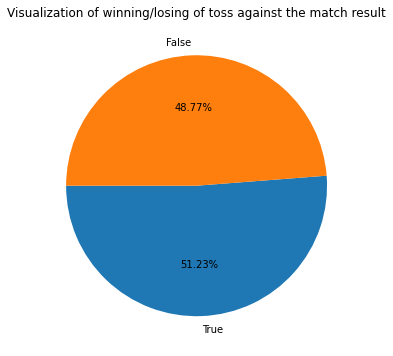

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv('ipl_matches.csv')
df=pd.DataFrame(data)
win=df.toss_winner==df.winner
win_counts=win.value_counts()
win_counts
plt.figure(figsize=(12,6))
plt.title('Visualization of winning/losing of toss against the match result')
plt.pie(win_counts,labels=win_counts.index,autopct='%1.2f%%', startangle=180)

# **Section 3**

## **1. Create Database**

In [40]:
import sqlite3 as sqlt
import pandas as pd

In [52]:
# method for checking the database connection status
def get_status(conn):
    try:
      conn.cursor()
      return ("Connected")
    except Exception as ex:
      return("Disconnected")
# creating the database and load it with dataset
try:
  conn=sqlt.connect('database.db')
  print("Connected succesfully!!")
  
  #load the data from the ipl_matches dataset into the database
  ipl_matches=pd.read_csv('ipl_matches.csv')
  ipl_matches.to_sql('matches',conn,if_exists='replace',index=False)
  if True:
    print("Succesfully added ipl_matches data to a sqlite table")
  else:
    print("Failed")

  #load the data from the ipl_ball_by_ball dataset into the database
  ball_by_ball=pd.read_csv('ipl_ball_by_ball.csv')
  ball_by_ball.to_sql('balls',conn,if_exists='replace',index=False)
  if True:
    print("Succesfully added ipl_ball_by_ball data to a sqlite table")
  else:
    print("Failed ")

  #load the data from the ipl_venue dataset into the database
  venues=pd.read_csv('ipl_venue.csv')
  venues.to_sql('venues',conn,if_exists='replace',index=False)
  if True:
    print("Succesfully added venue data to a sqlite table")
  else:
    print("Failed")
  cur=conn.cursor()
  conn.commit()
  print(get_status(conn)) # checking the database connection

except sqlt.Error as error:
  print("Error while connecting to sqlite", error)


finally:
  if conn:
    conn.close()
    print("The SQLite connection is closed")
    print(get_status(conn)) # checking the database connection


Connected succesfully!!
Succesfully added ipl_matches data to a sqlite table
Succesfully added ipl_ball_by_ball data to a sqlite table
Succesfully added venue data to a sqlite table
Connected
The SQLite connection is closed
Disconnected


## **2. Create a class**

In [ ]:
from pyspark.sql import SparkSession

class DataBase:
  #Constructor 
  #   Takes value from either a url if url provided or takes the data from the csv file
  def __init__(self, appName = 'IPL'):

    ##Creating a spark session whose name is given as appName
    self.spark = (SparkSession
    .builder
    .appName(appName)
    .getOrCreate())
    
    #Loading the matches dataset
    try:
      self.df_venue = self.spark.read.load("ipl_venue.csv",format="csv", sep=",", inferSchema="true", header="true")
    except:
      print("error")
    self.df_venue.createOrReplaceTempView('Venues')
    try:
      self.df_matches = self.spark.read.load("ipl_matches.csv",format="csv", sep=",", inferSchema="true", header="true")
    except:
      print("error")
    self.df_matches.createOrReplaceTempView('IPLmatches')
    try:
      self.df_ball_by_ball = self.spark.read.load("ipl_ball_by_ball.csv",format="csv", sep=",", inferSchema="true", header="true")
    except:
      print("error")
    self.df_ball_by_ball.createOrReplaceTempView('Ballbyball')  
  def get_query1_result(self):
    #return the answer to Q1 in Section 2 - return the answer as a dictionary
    self.new_df = self.df_venue.join(self.df_matches, on='venue_id', how='inner')
    self.new_ans_df1 = self.new_df.filter(self.new_df['eliminator']=='Y').select(['venue', 'eliminator']).groupBy('venue').count()
    self.ans = self.new_ans_df1.sort('count', ascending=False).select("Venue").toPandas()
    return {"Venue" : list(self.ans.Venue.values)[:3]}

  def get_query2_result(self):
    self.caught=self.df_ball_by_ball.where(self.df_ball_by_ball.dismissal_kind=="caught").groupBy('fielder').count()
    self.caught=self.caught.withColumnRenamed('count','catches')
    self.ans=self.caught.sort('catches',ascending=False).select('catches').toPandas()
    return{"Catches" : list(self.ans.catches.values)[:1]}
  
  def get_query3_result(self):
    self.method=self.df_matches.where(self.df_matches.method=='D/L')
    self.wicket=self.df_ball_by_ball.join(self.method,['match_id'],"inner")
    self.q3=self.wicket.where(self.wicket.is_wicket=='1').groupBy('bowler').count()
    self.q3=q3.withColumnRenamed('count','wickets')
    self.ans=self.q3.sort('wickets',ascending=False).select('bowler').toPandas()
    return{"Bowler" : list(self.ans.bowler.values)[:1]}

  def get_query4_result(self):
    self.powerplay_overs=self.df_ball_by_ball.where((self.df_ball_by_ball.overs >=7)&(self.df_ball_by_ball.overs<=20)&
                                                    (self.df_ball_by_ball.extras_type!='wides')&(self.df_ball_by_ball.extras_type!='noballs'))
    self.total=self.powerplay_overs.groupBy('batsman').sum('total_runs','ball')
    from pyspark.sql.functions import col
    self.q4=total.withColumn('Strike_rate',((col('sum(total_runs)')/col('sum(ball)'))*100))
    self.ans =self.q4.sort('Strike_rate',ascending=False).select('Strike_rate').toPandas()
    return{"Strike rate" : list(self.ans.Strike_rate.values)[:1]}

  def get_query5_result(self):
    self.extra_runs=self.df_ball_by_ball.where(self.df_ball_by_ball.extra_runs!=0).groupBy('match_id').sum('extra_runs')
    self.venue=self.df_matches.join(extra_runs,['match_id'],'inner')
    self.q5=self.df_venue.join(self.venue,['venue_id'],"inner")
    self.q5=self.q5.withColumnRenamed('sum(extra_runs)','total')
    self.ans=self.q5.sort('sum(extra_runs)',ascending=False).select('total','venue','city').toPandas()
    return{"Extra runs" : list(self.ans.total.values)[:1],"Stadium" : list(self.ans.venue.values)[:1],"City" : list(self.ans.city.values)[:1]}

  def get_query6_result(self):
    self.neutral_venues=self.df_matches.where(self.df_matches.neutral_venue=='1').groupBy('player_of_match').count()
    self.neutral_venues=self.neutral_venues.withColumnRenamed('count','total')
    self.ans=self.neutral_venues.sort('total',ascending=False).select('player_of_match').toPandas()
    return{"Player of the match" : list(self.ans.player_of_match.values)[:1]}

  def get_query7_result(self):
    self.data=self.df_ball_by_ball.filter((self.df_ball_by_ball.dismissal_kind!='retired hurt')&(self.df_ball_by_ball.dismissal_kind!='NA'))
    self.batsman=self.df_ball_by_ball.groupBy('batsman').sum('batsman_runs')
    self.batsman=self.batsman.withColumnRenamed('sum(batsman_runs)','total_runs')
    self.test=self.data.join(self.batsman,['batsman'],"inner")
    self.player_dismissed=self.test.groupBy('player_dismissed').count()
    self.player_dismissed=self.player_dismissed.withColumnRenamed('count','total')
    self.tr=self.batsman.join(self.player_dismissed).where(self.batsman.batsman == self.player_dismissed.player_dismissed)
    self.tr=self.tr.withColumn('Batting_average',(col('total_runs')/col('total')))
    self.ans=self.tr.sort('Batting_average',ascending=False).select('batsman','total_runs','player_dismissed','total','Batting_average').toPandas()
    return{"Batsman" : list(self.ans.batsman.values)[:10],"Runs" : list(self.ans.total_runs.values)[:10],
           "player_dismissed" : list(self.ans.player_dismissed.values)[:10], "Out Total" : list(self.ans.total.values)[:10],
           "Batting Average" : list(self.ans.Batting_average.values)[:10]}

  def get_query8_result(self):
    self.ump_1=self.df_matches.groupBy('umpire1').count()
    self.ump_1=self.ump_1.withColumnRenamed('count','count1')
    self.ump_2=self.df_matches.groupBy('umpire2').count()
    self.ump_2=self.ump_2.withColumnRenamed('count','count2')
    self.q8=self.ump_1.join(self.ump_2).where(self.ump_1.umpire1 == self.ump_2.umpire2)
    self.q8=self.q8.withColumn('total',(col('count1')+col('count2')))
    self.ans=self.q8.select('umpire1','total').sort('total',ascending=False).select('umpire1').toPandas()
    return{"Umpire_Name" : list(self.ans.umpire1.values)[:1]}

  def get_query9_result(self):
    self.kohli=self.df_ball_by_ball.filter(self.df_ball_by_ball.batsman=='V Kohli')
    self.kohli=self.kohli.groupBy('match_id').sum('batsman_runs')
    self.q9=self.df_matches.join(self.kohli,['match_id'],"inner")
    self.q9=self.df_venue.join(self.q9,['venue_id'],"inner")
    self.ans=self.q9.sort('sum(batsman_runs)',ascending=False).select('venue_id','venue','city').toPandas()
    return{"Venue_id" : list(self.ans.venue_id.values)[:1], "Venue" : list(self.ans.venue.values)[:1],
           "City" : list(self.ans.city.values)[:1]}

  def get_query10_result(self):
    from pyspark.sql import functions as F
    self.win=self.df_matches.withColumn("T/F",F.when(self.df_matches.toss_winner==self.df_matches.winner,1).otherwise(0))
    self.win=self.win.groupBy('T/F').count()
    self.win=win.withColumn('perct',((col('count')/816))*100)
    self.ans=self.win.select('perct').toPandas()
    return(self.ans)


In [ ]:
db = DataBase("IPL")

In [ ]:
#top 3 venues which hosted the most number of eliminator matches
qry1_result = db.get_query1_result()
print(qry1_result)

{'Venue': ['Dubai International Cricket Stadium', 'Sheikh Zayed Stadium', 'Sardar Patel Stadium, Motera']}


In [ ]:
#most number of catches taken by a player in IPL
qry2_result=db.get_query2_result()
print(qry2_result)

{'Catches': [118]}


In [ ]:
#highest wicket taker in matches which are affected by D/L method
qry3_result=db.get_query3_result()
print(qry3_result)

{'Bowler': ['R Ashwin']}


In [ ]:
#highest strike rate by a batsman in non powerplay overs
qry4_result=db.get_query4_result()
print(qry4_result)

{'Strike rate': [75.0]}


In [ ]:
#highest extra runs in a venue
qry5_result=db.get_query5_result()
print(qry5_result)

{'Extra runs': [38], 'Stadium': ['Eden Gardens'], 'City': ['Kolkata']}


In [ ]:
#cricketer with the most number of player of the match award in neutral venues
qry6_result=db.get_query6_result()
print(qry6_result)

{'Player of the match': ['YK Pathan']}


In [ ]:
#list of top 10 players with highest batting average
qry7_result=db.get_query7_result()
print(qry7_result)

{'Batsman': ['MN van Wyk', 'RD Gaikwad', 'AC Voges', 'KL Rahul', 'HM Amla', 'Iqbal Abdulla', 'DA Warner', 'JM Bairstow', 'CH Gayle', 'MS Dhoni'], 'Runs': [167, 204, 181, 2647, 577, 88, 5254, 790, 4772, 4632], 'player_dismissed': ['MN van Wyk', 'RD Gaikwad', 'AC Voges', 'KL Rahul', 'HM Amla', 'Iqbal Abdulla', 'DA Warner', 'JM Bairstow', 'CH Gayle', 'MS Dhoni'], 'Out Total': [3, 4, 4, 59, 13, 2, 123, 19, 116, 113], 'Batting Average': [55.666666666666664, 51.0, 45.25, 44.86440677966102, 44.38461538461539, 44.0, 42.71544715447155, 41.578947368421055, 41.13793103448276, 40.991150442477874]}


In [ ]:
#who officiated the most number of matches in IPL
qry8_result=db.get_query8_result()
print(qry8_result)

{'Umpire_Name': ['S Ravi']}


In [ ]:
#venue details of the match where V Kohli scored the highest individual runs in IPL
qry9_result=db.get_query9_result()
print(qry9_result)

{'Venue_id': [35], 'Venue': ['M.Chinnaswamy Stadium'], 'City': ['Bengaluru']}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


([<matplotlib.patches.Wedge at 0x7f4dd0b68110>,
 [Text(0.04233941135100639, -1.09918486809383, 'True'),
  Text(-0.04233941135100625, 1.09918486809383, 'False')],
 [Text(0.02309422437327621, -0.5995553825966345, '51.23%'),
  Text(-0.023094224373276136, 0.5995553825966345, '48.77%')])

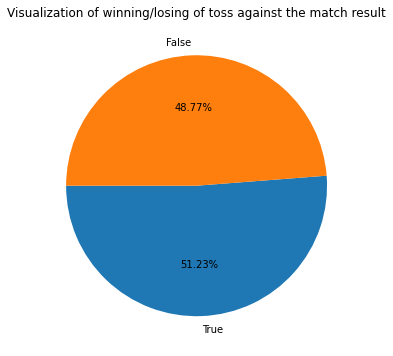

In [ ]:
#visualization of winning/lossing tosses impact on matches and the result
qry10_result=db.get_query10_result()
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Visualization of winning/losing of toss against the match result')
plt.pie(qry10_result,labels=win_counts.index,autopct='%1.2f%%', startangle=180)